In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = 'data/'
sz = 100
# architecture used
arch = resnext50
bs = 32

In [4]:
#list of directories in PATH
os.listdir(PATH)

['.ipynb_checkpoints', 'Validation', 'models', 'Training', 'tmp']

In [5]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
data = ImageClassifierData.from_paths(PATH, bs = bs, tfms=tfms, trn_name="Training", val_name='Validation')

In [6]:
#Give the number of classes
data.c

64

In [7]:
data.classes[:4]

['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3']

Number of pictures the traning set

In [8]:
data.trn_ds.n

31688

In [9]:
#Read in images and their labels given as sub-folder names
learn = ConvLearner.pretrained(arch, data, precompute = True)
lrf = learn.lr_find()

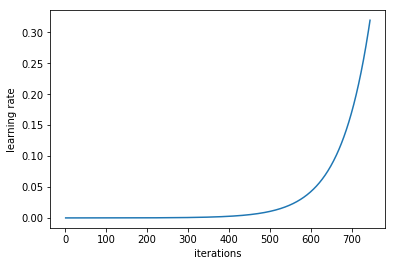

In [10]:
learn.sched.plot_lr()

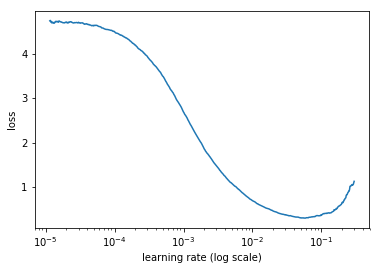

In [11]:
learn.sched.plot()

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.053698   0.086718   0.972882  


[array([0.08672]), 0.9728816740170779]

In [13]:
learn.precompute=False

In [14]:
learn.fit(5e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.075451   0.086569   0.972506  
    1      0.054968   0.076143   0.973726                     
    2      0.046704   0.072031   0.977573                     


[array([0.07203]), 0.9775734259172375]

In [15]:
learn.unfreeze()

In [16]:
lr=np.array([5e-5, 5e-4, 5e-3])

In [17]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.029371   0.032549   0.984611  
    1      0.017866   0.02732    0.987614                     
    2      0.017797   0.026553   0.987614                     
    3      0.017111   0.029747   0.986769                     
    4      0.016845   0.028255   0.986488                     
    5      0.016368   0.026623   0.988458                     
    6      0.017663   0.027019   0.98874                       


[array([0.02702]), 0.9887397954396172]

In [18]:
learn.save('model_resnext50')

In [19]:
learn.load('model_resnext50')

In [20]:
log_preds,y = learn.TTA()

probs = np.mean(np.exp(log_preds),0)

In [21]:
#preds = np.argmax(np.mean(log_preds, 0), axis = 1)

In [22]:
preds = np.argmax(probs, axis = 1)

In [23]:
accuracy_np(probs, y)

0.9887397954396172

In [24]:
#Define a function which return n_ex distincts numbers (here means examples) from one mask
def rand_by_mask(mask,n_ex): return np.random.choice(np.where(mask)[0], n_ex, replace=False)

In [25]:
#This function use previous function and return 4 examples corresponding to correct classfication(correct or wrong)
def rand_by_correct(is_correct, n_ex): return rand_by_mask((preds == data.val_y)==is_correct, n_ex)

In [26]:
#define a plot function
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [27]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [28]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [f'{np.max(probs[x],0)}\nPred : {data.classes[np.argmax(probs[x],0)]}\nActual : {data.classes[y[x]]}' for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


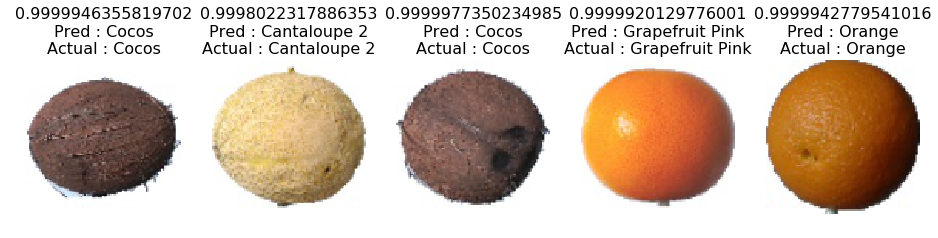

In [29]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True,5),"Correctly classified")

Incorrectly classified


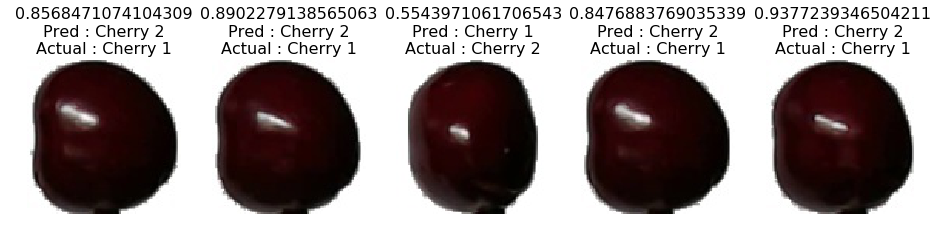

In [30]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False,5), "Incorrectly classified")

In [31]:
def most_by_mask(mask, mult,n_ex):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:n_ex]]

In [32]:
def most_by_correct(y, is_correct, n_ex):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult, n_ex)

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 164 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 166]]


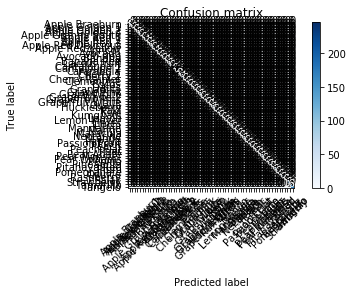

In [34]:
plot_confusion_matrix(cm, data.classes)

In [35]:
confus=[]
for i in range(cm.shape[0]):
    tot=np.sum(cm,1)[i]
    for j in range(cm.shape[0]):
        if cm[i,j]!=0 and cm[i,j]!=tot and data.classes[i]!=data.classes[j]:
            confus.append([cm[i,j], tot, round(cm[i,j]/tot,2), data.classes[i],data.classes[j]])
confus_arr = np.array(confus)

In [36]:
confus_arr

array([['1', '164', '0.01', 'Apple Granny Smith', 'Apple Golden 3'],
       ['56', '164', '0.34', 'Cherry 1', 'Cherry 2'],
       ['60', '246', '0.24', 'Cherry 2', 'Cherry 1'],
       ['3', '166', '0.02', 'Pepino', 'Grape White']], dtype='<U32')

[[108  56]
 [ 60 186]]


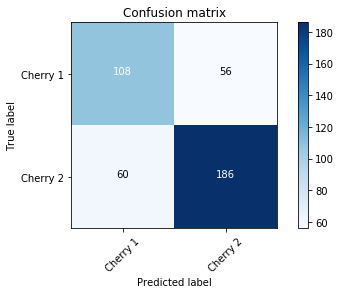

In [37]:
plot_confusion_matrix(cm[19:21,19:21], data.classes[19:21])